## Quantum Approximate Optimization Algorithm for the Max-Cut
In this section, we will solve the Maxcut Problem using QAOA with the help of the JijModeling and Qamomile libraries.

First, let's install and import the main libraries we will be using.

In [5]:
# !pip install qamomile[qiskit, quri_parts]

In [1]:
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

## What is the Max-Cut Problem

The Max-Cut problem is the problem of dividing the nodes of a graph into two groups such that the **number of edges cut (or the total weight of the edges cut, if the edges have weights)** is maximized. Applications include network partitioning and image processing (segmentation), among others.


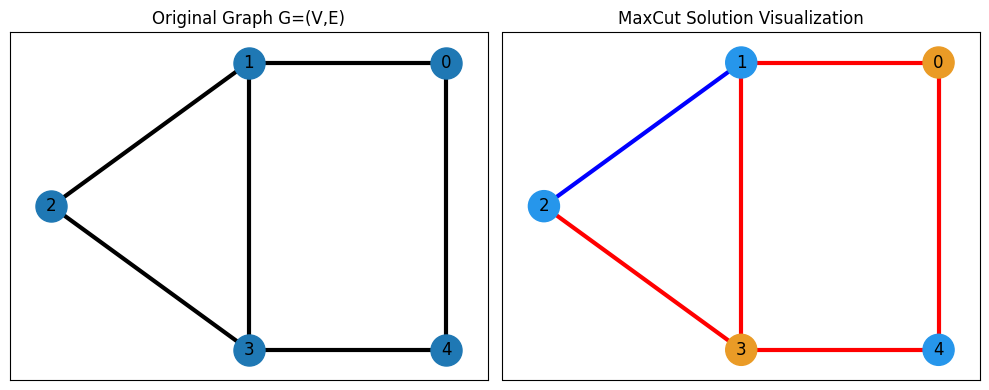

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
num_nodes = 5
edges = [(0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 1)]
G.add_nodes_from(range(num_nodes))
G.add_weighted_edges_from(edges)
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}

cut_solution = {(1,): 1.0, (2,): 1.0, (4,): 1.0}
edge_colors = []


def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
) -> Tuple[List[str], List[str]]:
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors


edge_colors, node_colors = get_edge_colors(G, cut_solution)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title("Original Graph G=(V,E)")
nx.draw_networkx(G, pos, ax=axes[0], node_size=500, width=3, with_labels=True)
axes[1].set_title("MaxCut Solution Visualization")
nx.draw_networkx(
    G,
    pos,
    ax=axes[1],
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)

plt.tight_layout()
plt.show()

## Constructing the Mathematical Model

The Max-Cut problem can be formulated with the following equation:

$$
  \min \quad -\frac{1}{2} \sum_{(i,j) \in E} w_{i,j}(s_i s_j - 1)  
$$

Note that this equation is expressed using Ising variables $ s \in \{ +1, -1 \} $. In this case, we want to formulate it using the binary variables $ x \in \{ 0, 1 \} $ from JijModeling. Therefore, we perform the conversion between Ising variables and binary variables using the following equations:

$$
    x_i = \frac{1 + s_i}{2} \quad \Rightarrow \quad s_i = 2x_i - 1
$$


In [3]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    w = jm.Placeholder("w", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, w[e[0], e[1]] * (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

## Preparing Instance Data

Next, we will solve the Max-Cut Problem for the following graph. The data for the specific problem being solved is referred to as instance data.

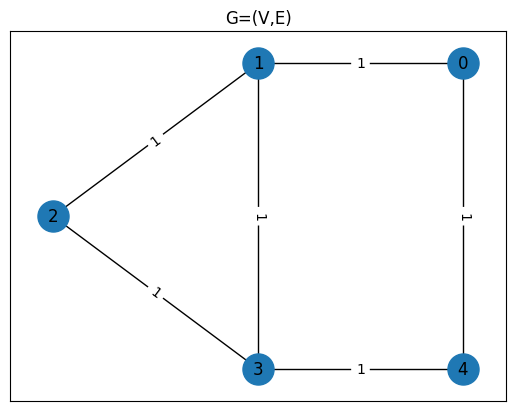

In [4]:
import networkx as nx
import numpy as np
from IPython.display import display, Latex

G = nx.Graph()
num_nodes = 5
edges = [(0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 1)]
G.add_nodes_from(range(num_nodes))
G.add_weighted_edges_from(edges)

weight_matrix = nx.to_numpy_array(G)

edge_labels = nx.get_edge_attributes(G, "weight")

plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)
label_key = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

In [5]:
V = num_nodes
E = edges
w = weight_matrix

data = {"V": V, "E": E, "w": w}

data

{'V': 5,
 'E': [(0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 1)],
 'w': array([[0., 1., 0., 0., 1.],
        [1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1.],
        [1., 0., 0., 1., 0.]])}

## Creating a Compiled Instance
We perform compilation using the JijModeling-Transpiler by providing the formulation and the instance data prepared earlier. This process yields an intermediate representation of the problem with the instance data substituted.

In [6]:
compiled_model = jmt.compile_model(problem, data)

## Converting Compiled Instance to QAOA Circuit and Hamiltonian
We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods. The number of QAOA layers, $P$, is fixed to be $7$ here.  

In [7]:
import qamomile.core as qm

qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)

qaoa_converter.ising_encode()

qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

p = 7

qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

## Visualization of QAOA Circuit
Qamomile provides a method to visualize the quantum circuit. You can use the plot_quantum_circuit function to visualize the QAOA quantum circuit.

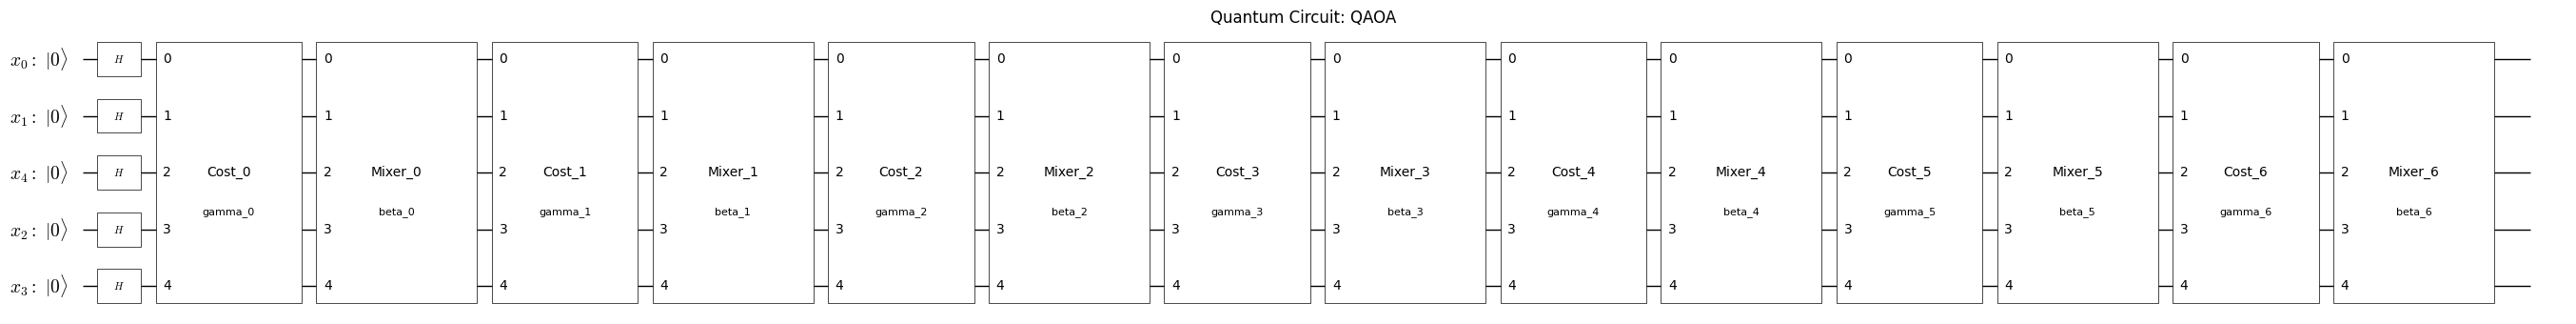

In [8]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

## Converting Compiled Instance to QAOA Circuit and Hamiltonian
We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods. The number of QAOA layers, $P$, is fixed to be 7.


In [9]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)

# Transpile the QAOA Hamitltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIZI', 'ZIIZI', 'ZZIII', 'ZIZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

## Running QAOA
We run QAOA to optimize the parameters. Here, we use COBYLA as the optimizer.

In [10]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
# Cost estimator function
estimator = qk_pr.StatevectorEstimator()


def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf


# Create initial parameters
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

# Run QAOA optimization
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.7114324294362708
       x: [ 4.487e-01 -2.108e-01 ... -2.221e-01 -7.058e-01]
    nfev: 182
   maxcv: 0.0


## Result Visualization
By repeating the optimization, we can observe that the energy decreases and converges.

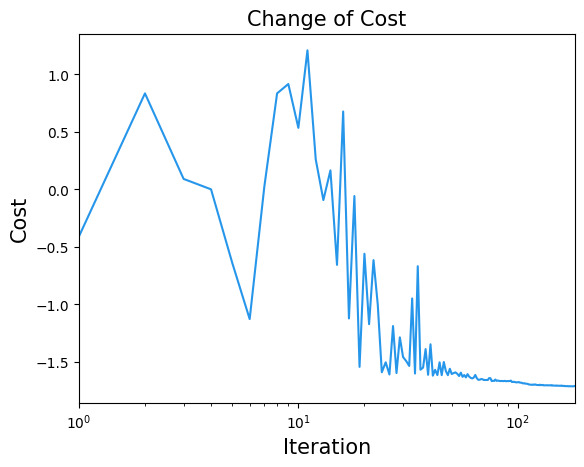

In [11]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Now, let's run the Optimized paremeter on qiskit `StatevectorSampler`.

In [12]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## Evaluating the Results
From the job counts obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

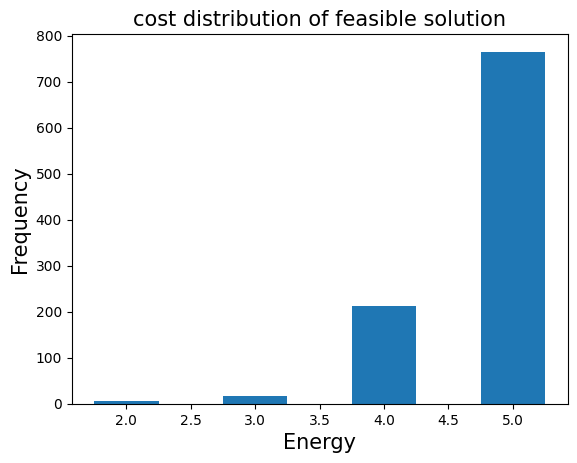

{5.0: 765, 4.0: 212, 2.0: 6, 3.0: 17}

In [13]:
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
plot_data = {}
for sample in sampleset.feasibles():
    if sample.eval.objective in plot_data:
        plot_data[sample.eval.objective] += sample.num_occurrences
    else:
        plot_data[sample.eval.objective] = sample.num_occurrences

plt.bar(plot_data.keys(), plot_data.values(), width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

plot_data

In [14]:
target_energy = max(list(plot_data.keys()))
target_samples = [
    sample for sample in sampleset.feasibles() if sample.eval.objective == target_energy
]

for sample in target_samples:
    print(f"Energy: {sample.eval.objective}")
    print(f"Occurrences: {sample.num_occurrences}")
    print(f"Solution: {sample.var_values['x'].values}")

best_sample = target_samples[0]
best_sample.var_values["x"].values

Energy: 5.0
Occurrences: 202
Solution: {(3,): 1.0, (0,): 1.0}
Energy: 5.0
Occurrences: 200
Solution: {(4,): 1.0, (2,): 1.0, (1,): 1.0}
Energy: 5.0
Occurrences: 197
Solution: {(1,): 1.0, (4,): 1.0}
Energy: 5.0
Occurrences: 166
Solution: {(2,): 1.0, (3,): 1.0, (0,): 1.0}


{(3,): 1.0, (0,): 1.0}

## Plotting the Solution
From the obtained results, we select one solution that minimizes the objective function value and plot it. (The red are the edges been cutted in Max-Cut.)

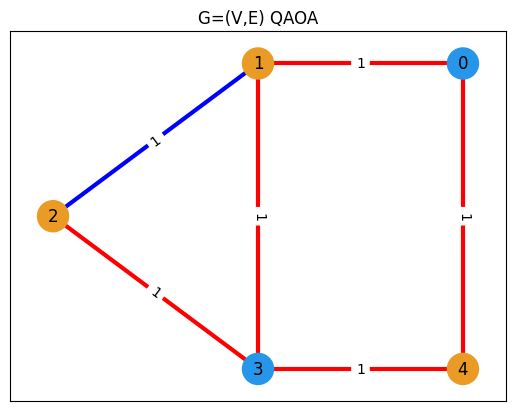

In [15]:
best_values = best_sample.var_values["x"].values
edge_colors, node_colors = get_edge_colors(G, best_values)
edge_labels = nx.get_edge_attributes(G, "weight")

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    G,
    pos,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)
label_key = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

Let's plot the results for different P layers and see how they affect the success probability.

In [16]:
P_layer = 8
p_num_occurrences = []
for i in range(1, P_layer + 1):
    qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=i)
    initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * i)
    qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
    qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
    result = minimize(
        estimate_cost,
        initial_params,
        method="COBYLA",
        options={"maxiter": 20000, "tol": 1e-2},
    )
    sampler = qk_pr.StatevectorSampler()
    qk_circuit.measure_all()
    job = sampler.run([(qk_circuit, result.x)], shots=10000)
    job_result = job.result()[0]
    qaoa_counts = job_result.data["meas"]
    sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
    plot_data = {}
    for sample in sampleset.feasibles():
        if sample.eval.objective in plot_data:
            plot_data[sample.eval.objective] += sample.num_occurrences
        else:
            plot_data[sample.eval.objective] = sample.num_occurrences
    p_num_occurrences.append(plot_data[max(list(plot_data.keys()))])

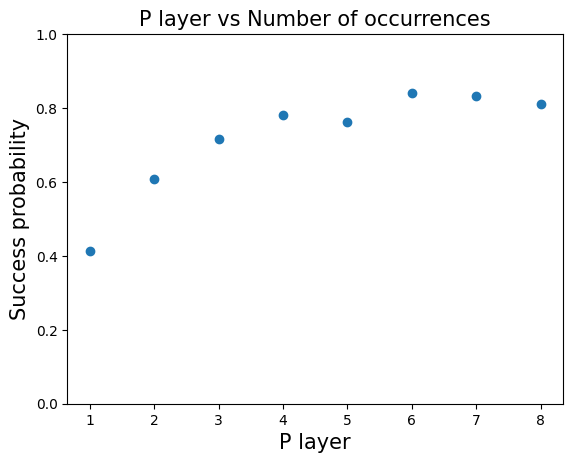

In [17]:
p_num_occurrences = p_num_occurrences
p_list = range(1, len(p_num_occurrences) + 1)
p_num_occurrences_data = [num / 10000 for num in p_num_occurrences]

plt.scatter(p_list, p_num_occurrences_data)
plt.title("P layer vs Number of occurrences", fontsize=15)
plt.xlabel("P layer", fontsize=15)
plt.ylabel("Success probability", fontsize=15)
plt.ylim(0.0, 1.0)
plt.show()